In [ ]:
# !pip install pytorch-tabnet
# !pip install torch
# !pip install nltk
# !pip install tensorflow
# !pip install konlpy
# !pip install mecab-python
# !bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
# !pip install google-api-python-client pandas tqdm
# !pip install gensim

   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ----- ---------------------------------- 1.8/13.3 MB 10.1 MB/s eta 0:00:02
   ------------- -------------------------- 4.5/13.3 MB 10.8 MB/s eta 0:00:01
   --------------------- ------------------ 7.1/13.3 MB 11.2 MB/s eta 0:00:01
   ---------------------------- ----------- 9.4/13.3 MB 11.3 MB/s eta 0:00:01
   ----------------------------------- ---- 11.8/13.3 MB 11.4 MB/s eta 0:00:01
   ---------------------------------------- 13.3/13.3 MB 10.9 MB/s eta 0:00:00


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from nltk import FreqDist

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

from nltk.corpus import stopwords

# import spacy
# from konlpy.tag import Mecab
# from konlpy.tag import Okt

import torch
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabNetRegressor

from nltk.tokenize import word_tokenize
from nltk.tokenize import WordPunctTokenizer
# from tensorflow.keras.preprocessing.text import text_to_word_sequence

In [26]:
from matplotlib import rc
import matplotlib.font_manager as fm

# Windows 기본 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'

# 마이너 경고 제거 (한글 음절 없는 글꼴 경고)
plt.rcParams['axes.unicode_minus'] = False

In [17]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")
data = pd.read_table('ratings.txt') # 데이터프레임에 저장
data[:10]

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1
5,2190435,사랑을 해본사람이라면 처음부터 끝까지 웃을수 있는영화,1
6,9279041,완전 감동입니다 다시봐도 감동,1
7,7865729,개들의 전쟁2 나오나요? 나오면 1빠로 보고 싶음,1
8,7477618,굿,1
9,9250537,바보가 아니라 병 쉰 인듯,1


In [18]:
print('전체 샘플의 수 : {}'.format(len(data)))
# f-string
print(f"전체 샘플의 수 : {format(len(data))}")

전체 샘플의 수 : 200000
전체 샘플의 수 : 200000


In [19]:
sample_data = data[:100] # 임의로 100개만 저장

In [20]:
sample_data['document'] = sample_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
# 한글과 공백을 제외하고 모두 제거
sample_data[:10]

C:\Users\human\AppData\Local\Temp\ipykernel_4436\2778763599.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_data['document'] = sample_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)


,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1
5,2190435,사랑을 해본사람이라면 처음부터 끝까지 웃을수 있는영화,1
6,9279041,완전 감동입니다 다시봐도 감동,1
7,7865729,개들의 전쟁 나오나요 나오면 빠로 보고 싶음,1
8,7477618,굿,1
9,9250537,바보가 아니라 병 쉰 인듯,1


In [21]:
import fugashi
import tqdm
stopwords=['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

tagger = fugashi.Tagger()
tokenized_data = []


for sentence in tqdm.tqdm(sample_data['document']):
    sentence = str(sentence).strip()
    
    if not sentence:
        continue

    tokenized_sentence = [word.surface for word in tagger(sentence)]
    
    stopwords_removed_sentence = [word for word in tokenized_sentence 
                                  if word not in stopwords
                                  and len(word) >= 2
                                  and word.isalpha()]  # 한글/영문만
    if stopwords_removed_sentence:
        tokenized_data.append(stopwords_removed_sentence)



100%|██████████| 100/100 [00:00<00:00, 49766.30it/s]


In [22]:
vocab = FreqDist(np.hstack(tokenized_data))
print('단어 집합의 크기 : {}'.format(len(vocab)))

단어 집합의 크기 : 614


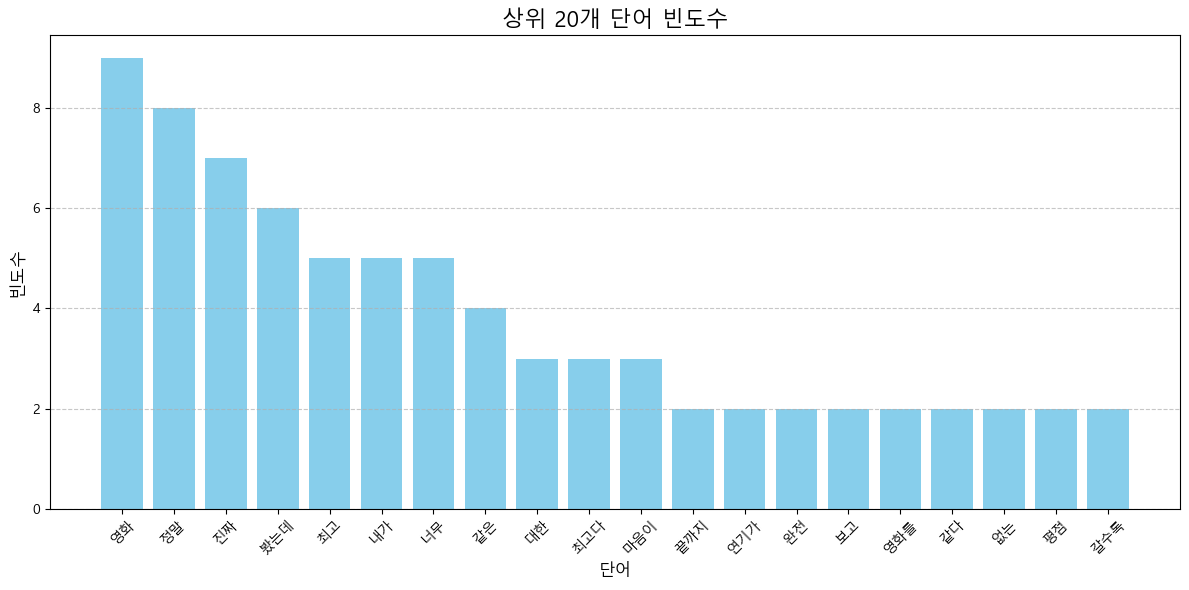

In [25]:
# 상위 20개 단어 추출
top_words = vocab.most_common(20)
words, counts = zip(*top_words)

# 시각화
plt.figure(figsize=(12, 6))
plt.bar(words, counts, color='skyblue')
plt.title('상위 20개 단어 빈도수', fontsize=16)
plt.xlabel('단어', fontsize=12)
plt.ylabel('빈도수', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()